In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import re
import csv
import pickle

import numpy as np
from scipy import interpolate, stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
from aatw.units_constants import *
from aatw.geometry import Glbd
from aatw.map_utils import plot_hv

## 0. Prep

In [3]:
def sample_from_pdf(pdf_func, start, end, num_samples, num_partition=1000):
    """pdf_func must be vectorized"""
    x = np.linspace(start, end, num_partition)
    cdf = np.cumsum(pdf_func(x) * np.diff(x, prepend=x[0]))
    cdf /= cdf[-1]
    inverse_cdf = interpolate.interp1d(cdf, x)
    return inverse_cdf(np.random.uniform(0, 1, num_samples))

In [5]:
snrlist = pickle.load(open("../data/SNR/snrlist_none.p", 'rb'))

## 1. Location distribution

In [11]:
def snr_pdf_AKBVS(stz):
    """SNR location pdf.
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    Vectorized in first dimension.
    """
    s, t, z = stz[:,0], stz[:,1], stz[:,2]
    s0 = 2.9 # [kpc]
    z0 = 0.095 # [kpc]
    return np.exp(-s/s0) * np.exp(-np.abs(z)/z0)

def sample_snr_stz_AKBVS(num_samples):
    """SNR location sampler.
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    """
    s0 = 2.9 # [kpc]
    s_pdf = lambda s: np.exp(-s/s0)
    s_start, s_end = 0, 15 # [kpc]
    
    z0 = 0.095 # [kpc]
    z_pdf = lambda z: np.exp(-np.abs(z)/z0)
    z_start, z_end = -1, 1 # [kpc]
    
    s_samples = sample_from_pdf(s_pdf, s_start, s_end, num_samples)
    z_samples = sample_from_pdf(z_pdf, z_start, z_end, num_samples)
    t_samples = np.random.uniform(0, 2*np.pi, num_samples)
    
    return np.stack([s_samples,
                     t_samples,
                     z_samples], axis=-1)

In [12]:
def snr_pdf_G(stz):
    """SNR location pdf.
    Following 1508.02931 Green.
    Vectorized in first dimension.
    
    Take z to be Uniform(-0.1, 0.1).
    """
    s, t, z = stz[:,0], stz[:,1], stz[:,2]
    
    R_sun = 8.5 # [kpc]
    alpha = 1.09 # [1]
    beta = 3.87 # [1]
    return (s/R_sun)**alpha * np.exp(-beta*(s-R_sun)/R_sun) * (np.abs(z) < 0.1)

def sample_snr_stz_G(num_samples):
    """SNR location sampler.
    Following 1508.02931 Green.
    Take z to be Uniform(-0.1, 0.1).
    """
    R_sun = 8.5 # [kpc]
    alpha = 1.09 # [1]
    beta = 3.87 # [1]
    s_pdf = lambda s: (s/R_sun)**alpha * np.exp(-beta*(s-R_sun)/R_sun)
    s_start, s_end = 0, 15 # [kpc]
    
    s_samples = sample_from_pdf(s_pdf, s_start, s_end, num_samples)
    z_samples = np.random.uniform(-0.1, 0.1, num_samples)
    t_samples = np.random.uniform(0, 2*np.pi, num_samples)
    
    return np.stack([s_samples,
                     t_samples,
                     z_samples], axis=-1)

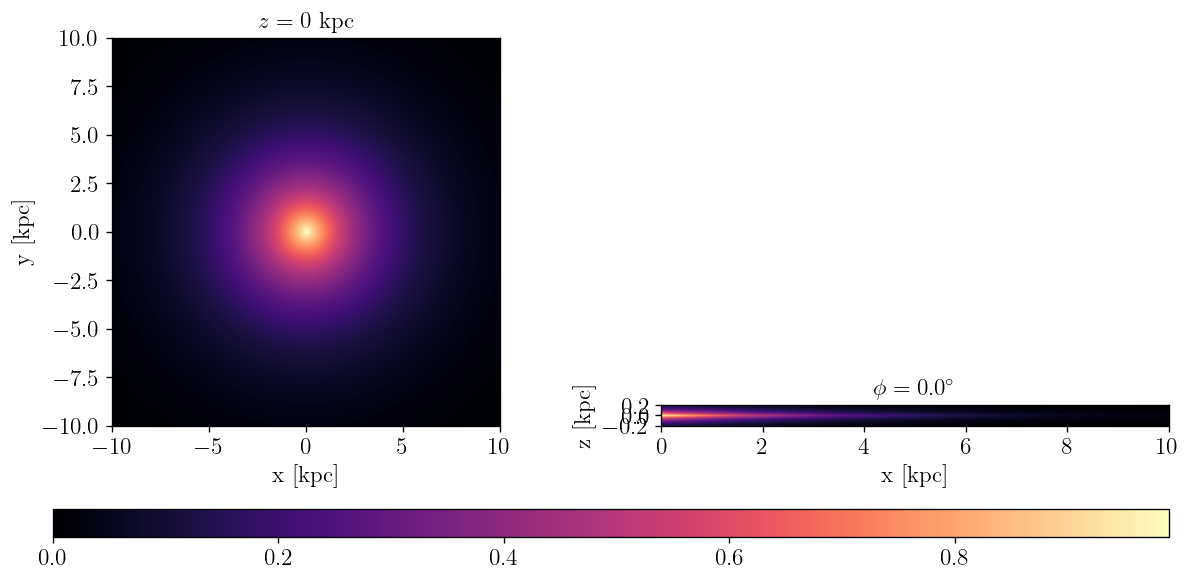

In [13]:
plot_hv(snr_pdf_AKBVS, smax=10, zmax=0.2, npix=200)

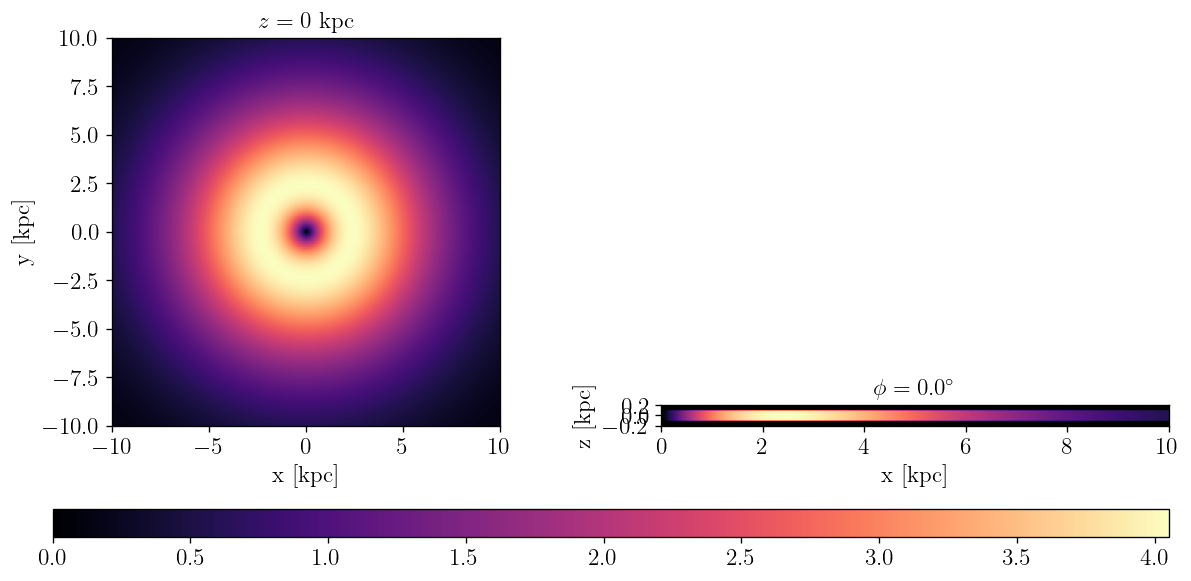

In [14]:
plot_hv(snr_pdf_G, smax=10, zmax=0.2, npix=200)

In [18]:
lbd_valid = np.array([[snr.l, snr.b, snr.d] for snr in snrlist])
lbd_valid[:, 0] = np.where(lbd_valid[:, 0] > np.pi, lbd_valid[:, 0] - 2*np.pi, lbd_valid[:, 0])

lbd_AKBVS = Glbd(sample_snr_stz_AKBVS(102))
lbd_G = Glbd(sample_snr_stz_G(102))

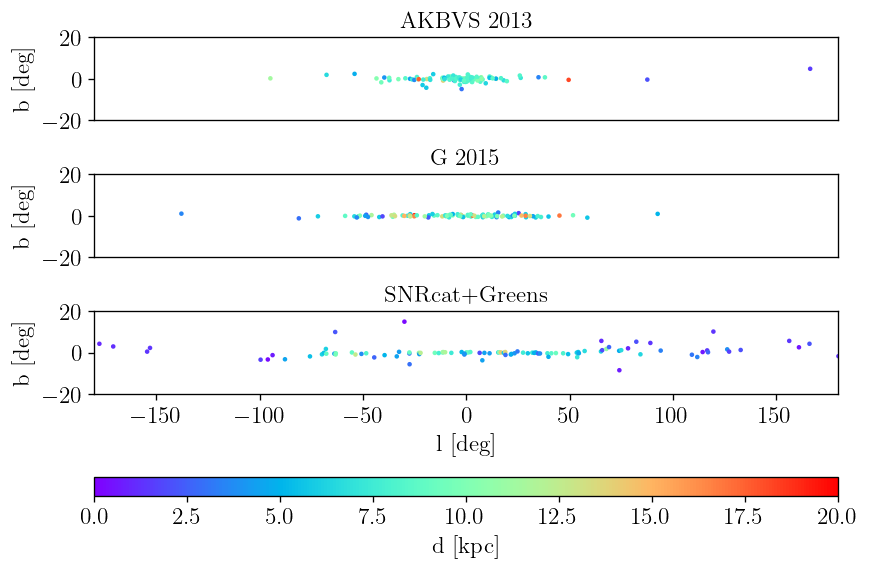

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

norm = mpl.colors.Normalize(vmin=0, vmax=20)

im = axs[0].scatter(np.rad2deg(lbd_AKBVS[:, 0]), np.rad2deg(lbd_AKBVS[:, 1]), c=lbd_AKBVS[:, 2], s=3, cmap='rainbow', norm=norm)
axs[1].scatter(np.rad2deg(lbd_G[:, 0]), np.rad2deg(lbd_G[:, 1]), c=lbd_G[:, 2], s=3, cmap='rainbow', norm=norm)
axs[2].scatter(np.rad2deg(lbd_valid[:, 0]), np.rad2deg(lbd_valid[:, 1]), c=lbd_valid[:, 2], s=3, cmap='rainbow', norm=norm)

axs[0].set(xlim=(-180, 180), ylim=(-20, 20), aspect=1)
axs[1].set(xlim=(-180, 180), ylim=(-20, 20), aspect=1)
axs[2].set(xlim=(-180, 180), ylim=(-20, 20), aspect=1)
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', aspect=40)
cbar.set_label('d [kpc]')

axs[0].set(ylabel='b [deg]', title='AKBVS 2013', xticks=[])
axs[1].set(ylabel='b [deg]', title='G 2015', xticks=[])
axs[2].set(ylabel='b [deg]', title='SNRcat+Greens', xlabel='l [deg]');

## 2. spectral index from Green's catalog

In [61]:
si_arr = []

with open('../data/SNR/Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line = line.split('\n')[0].lstrip()
        line = re.sub(' +', ' ', line)
        si_str = line.split(' ')[10]
        
        si_str = si_str.replace('?', '')
        si_str = si_str.replace('varies', '')
        if si_str != '':
            si_arr.append(float(si_str))
            
si_arr = np.array(si_arr)

In [62]:
# fit
skewness, loc, scale = stats.skewnorm.fit(si_arr)

In [63]:
# sample
stats.skewnorm.rvs(skewness, loc=loc, scale=scale, size=10)

array([0.35959126, 0.5662127 , 0.57802733, 0.56808455, 0.22667893,
       0.6146251 , 0.66387124, 0.51012354, 0.5627416 , 0.72362293])

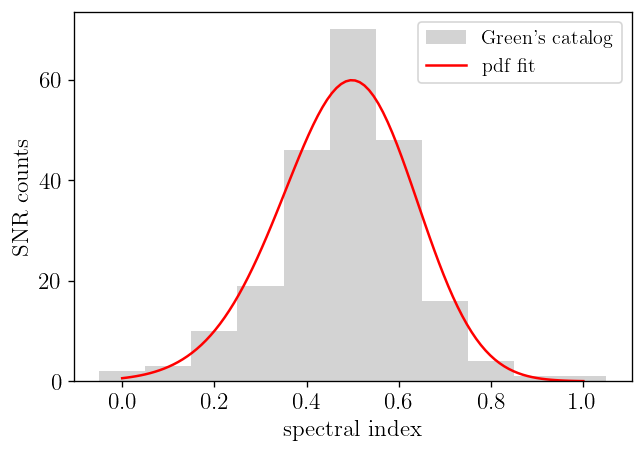

In [71]:
fig, ax = plt.subplots()

si_bins = np.linspace(-0.05, 1.05, 12)
si_counts, _, _ = ax.hist(si_arr, bins=si_bins, color='lightgray', label='Green\'s catalog')

plot_x = np.linspace(0, 1, 100)
plot_y = stats.skewnorm.pdf(plot_x, skewness, loc=loc, scale=scale)
ax.plot(plot_x, plot_y * len(si_arr) * np.diff(si_bins)[0], color='red', label='pdf fit')
ax.set(xlabel='spectral index', ylabel='SNR counts')
ax.legend();

## 3. angular size from SNRcat

In [105]:
date_str = '20230426'

size_arr = []

with open(f'../data/SNR/SNRcat{date_str}-SNR_dehead.csv', 'r') as csvf:
    csv_reader = csv.DictReader(csvf, delimiter=';')
    
    for i, row in enumerate(csv_reader):
        size = float(row['size_coarse (arcmin)']) * arcmin # [rad]
        if size > 0:
            size_arr.append(size)
size_arr = np.array(size_arr)
print(np.min(size_arr), np.max(size_arr))

2.0362174606600513e-05 0.41887902047863906


In [108]:
np.max(size_arr[size_arr<0.1])

0.07853981633974483

In [107]:
np.rad2deg(0.41)

23.49126960036375

In [96]:
# fit
loc, scale = stats.expon.fit(size_arr)

In [98]:
# sample
stats.expon.rvs(loc=loc, scale=scale, size=10)

array([0.00270024, 0.00466171, 0.00745496, 0.00269792, 0.00872989,
       0.00764918, 0.00090943, 0.00321078, 0.00013797, 0.01588839])

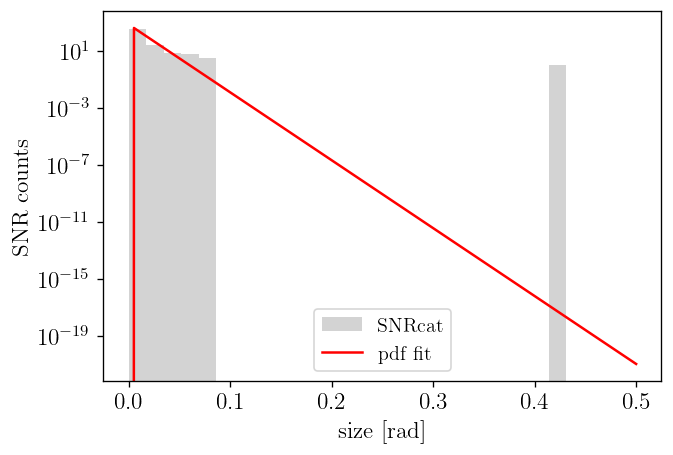

In [102]:
fig, ax = plt.subplots()

size_bins = np.linspace(0, 0.5, 30)
size_counts, _, _ = ax.hist(size_arr, bins=size_bins, color='lightgray', label='SNRcat')

plot_x = np.linspace(0, 0.5, 100)
plot_y = stats.expon.pdf(plot_x, loc=loc, scale=scale)
ax.plot(plot_x, plot_y * len(size_arr) * np.diff(size_bins)[0], color='red', label='pdf fit')
ax.set(yscale='log')
ax.set(xlabel='size [rad]', ylabel='SNR counts')
ax.legend();

## $L_\mathrm{peak}$

## $T_\mathrm{peak}$

## rate

CCSNR: $3.2^{+7.3}_{-2.6}$ / 100 yr \
IaSNR: $4.6^{+7.4}_{-2.7}$ / 100 yr

In [ ]:
def poisson_process(rate, total_time):
    ts = []
    t = np.random.exponential(1/rate)
    while t < total_time:
        ts.append(t)
        t += np.random.exponential(1/rate)
    return ts